# Test prodromal model from Berg et al 2015

doi: 10.1002/mds.26431

"
- Step 1: Establish the prior from the table51.25
- Step 2: Calculate total LR 1.2 (male)x 1.5 (pesti-cide)x 0.88   (coffee) 1.25 x  (nonsmoker) x130(RBD) x4.0 (olfaction) x 0.8 (no constipation) x 0.85(nodepressionoranxiety), 0.88(nosomnolence)x 1.0(borderline motor testing – result omitted)= 616.
- Step  3: Calculate  post-test  probability, using  one  oftwo methods:a. Make  an  exact  quantitative  probability  calculation using calculators. Result 89%, orb. From Table 2, LR must be 300. Actual LR>300, sopatient meets criteria for probable prodromal PD."

In [2]:
import numpy as np
import pandas as pd

import pylab as plt
import seaborn as sns

import yaml

import sys
sys.path.insert(1,'../../make_figures/')
import plots
sys.path.insert(1,'../3_logistic_regression/')
import load_modalities

In [3]:
def get_prior(df,age='age'):
    d = {range(0, 55): 0.4, range(55, 60): 0.75, range(60, 65): 1.25, range(65, 70): 2.0, 
         range(70, 75): 2.5, range(75, 80): 3.5, range(80,130): 4.0}
    df['prior'] = round(df[age]).apply(lambda x: next((v for k, v in d.items() if x in k), 0))
    return df
def calculate_LR(df,kind='Heinzel'):
    if kind == 'Berg':
        formula = pd.DataFrame([[1.2,0.8],[1.5,1],[0.88,1.35],[1.25,1],[0.8,1],[0.45,1],
                          [130,0.62],[4,0.43],[2.2,0.8],[1.8,0.85],[2.2,0.88],[40,0.65],[10,0.7],[2.0,0.9],
                           [1.9,0.9],[1.2,0.87],[2.5,1]],
                           index=['male','pesticide_exposure','coffee','SmokeStatus_Never','SmokeStatus_Previous',
                                  'SmokeStatus_Current','RBD_beforePD','Hyposmia_beforePD',
                                  'Constipation_beforePD','DepressionOrAnxiety_beforePD','DaytimeSleepiness_Often',
                                 'postiveDaT','UPDRS>3','ErectileDysfunction_beforePD','UrinaryIncontinence_beforePD',
                                 'OrthostaticHypotension_beforePD','family_Parkinsonsdisease'],
                           columns=['yes','no'])
    elif kind == 'Heinzel':
                formula = pd.DataFrame([[1.2,0.8],[1.5,1],[0.88,1.35],[1.2,1],[0.91,1],[0.51,1],
                          [130,0.65],[6.4,0.4],[2.5,0.82],[1.6,0.88],[2.7,0.86],[43.3,0.66],[9.6,0.55],[3.4,0.87],
                           [2.0,0.9],[18.5,0.88],#[2.5,1],
                                        [1.57,1],[0.45,1],[1.3,0.91],[1.8,1],[0.88,1],[1.8,0.88]],
                           index=['male','pesticide_exposure','coffee','SmokeStatus_Never','SmokeStatus_Previous',
                                  'SmokeStatus_Current','RBD_beforePD','Hyposmia_beforePD',
                                  'Constipation_beforePD','DepressionOrAnxiety_beforePD','DaytimeSleepiness_Often',
                                 'postiveDaT','UPDRS>3','ErectileDysfunction_beforePD','UrinaryIncontinence_beforePD',
                                 'OrthostaticHypotension_beforePD',#'family_Parkinsonsdisease',
                                 'PRS_highQ','PRS_lowQ','physical_inactivity','urate_low','urate_high','cognitive_deficit'],
                           columns=['yes','no'])
    else:
        print("not a valid version: try 'Heinzel' or 'Berg'")
        return []
    # create missing cols
    df_new = df.copy(deep=True)
    df_new['DepressionOrAnxiety_beforePD'] = df_new[['Depression_beforePD','Anxiety_beforePD']].max(axis=1)
    df_new['SmokeStatus_Never'] = (df_new[['SmokeStatus_Previous','SmokeStatus_Current']].max(axis=1) == 0).astype(int)
    df_new['PRS_Q'] = pd.qcut(df_new['PRS'],q=4,labels=['lowQ','midQlow','midQhigh','highQ'])
    df_new['PRS_highQ'] = (df_new['PRS_Q']=='highQ').astype(int)
    df_new['PRS_lowQ'] = (df_new['PRS_Q']=='lowQ').astype(int)
    #low physical activity is defined as less than 1 hour per week of activity causing increased respiratory or heart rate or sweating.
    df_new['physical_inactivity'] = (df_new['total_MVPA_hours']/2/60 < 1).astype(int) # convert 30sec into hours
    # low defined as <5mg/dL and high as >5.6mg/dl only in men
    df_new['urate_low'] = ((df_new['Urate']/59.48) <5).astype(int) * df_new['male'] #conversion factor as in UKBB given as umol/L
    df_new['urate_high'] = ((df_new['Urate']/59.48) >5.6).astype(int) * df_new['male'] #conversion factor as in UKBB given as umol/L
    #TODOdf_new['cognitive_deficit']
    # convert
    intersect = np.intersect1d(df_new.columns,formula.index)
    df_new = df_new[intersect]
    df_new = df_new.replace([0,1],['no','yes'])
    df_new = pd.get_dummies(df_new)
    # multiply
    df_new['LR'] = 1
    for column in intersect:
        try:
            yes = (df_new[f'{column}_yes'] * formula.loc[column,'yes']).replace(0,1)
        except:
            yes = pd.Series(1,index=df_new.index)
        try:
            no  = (df_new[f'{column}_no'] * formula.loc[column,'no']).replace(0,1)
        except:
            no = pd.Series(1,index=df_new.index)
        df_new['LR'] *= yes
        df_new['LR'] *= no
    return df_new['LR']

def get_post_prob(df,age='age'):
    d = {range(0, 55): 1000, range(55, 60): 515, range(60, 65): 300, range(65, 70): 180, 
         range(70, 75): 155, range(75, 80): 110, range(80,130): 95}
    df['PD_thresh'] = round(df[age]).apply(lambda x: next((v for k, v in d.items() if x in k), 0))
    df['PD'] = (df['LR'] >= df['PD_thresh']).astype(int)
    odds = ((df['prior']/100)/(1-(df['prior']/100))) * df['LR']
    df['prob_PD'] = odds/(1+odds)
    return df

In [4]:
# get data
img_path = '/scratch/c.c21013066/images/ukbiobank/accelerometer/models'
model_path = '/scratch/c.c21013066/data/ukbiobank/analyses/acc_models'
data_path = '/scratch/c.c21013066/data/ukbiobank'

covs,allfeatures,allfeatures_scale,blood,blood_scale,lifestyle,lifestyle_scale,genetics,genetics_scale,prod,prod_acc = load_modalities.load_features(f'{data_path}')

merged = pd.read_csv(f'{data_path}/merged_data/populationNoOsteoAllHC.csv').set_index('eid')

In [5]:
# calculate probability of having prodromal PD
df = get_prior(merged,age='accelerometry_age')
df['LR'] = calculate_LR(df,kind='Berg')
df = get_post_prob(df,age='accelerometry_age')

ImportError: cannot import name 'find_stack_level' from 'pandas.util._exceptions' (/scratch/c.c21013066/docker/envs/sksurvauprc/lib/python3.8/site-packages/pandas/util/_exceptions.py)

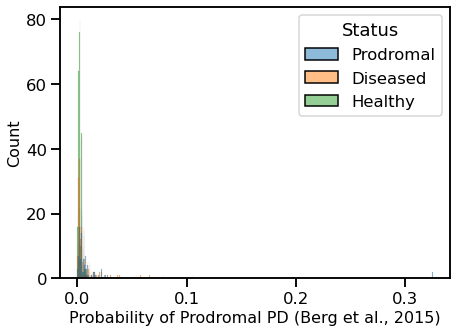

In [45]:
fig = plt.figure(figsize=(7,5))
plots.plot_context()
ax = sns.histplot(data=df,hue='Status',x='prob_PD')
ax.set_xlabel('Probability of Prodromal PD (Berg et al., 2015)');

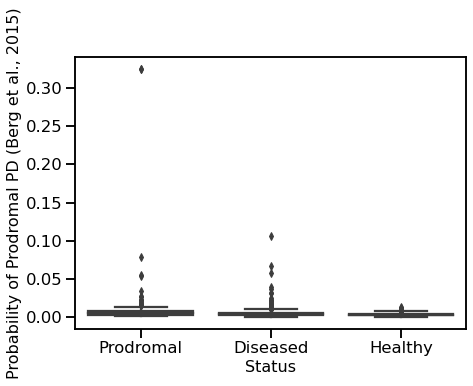

In [46]:
fig = plt.figure(figsize=(7,5))
plots.plot_context()
ax = sns.boxplot(data=df,x='Status',y='prob_PD')
ax.set_ylabel('Probability of Prodromal PD (Berg et al., 2015)');

In [42]:
df.loc[df['prob_PD']>0.5,'Status']

eid
4887189    Diseased
Name: Status, dtype: object

In [43]:
df[df['RBD']==1].iloc[:,-4:]

,prior,LR,PD_thresh,prob_PD
eid,,,,
1488239,2.00,8.741136,180,0.151385
1920547,0.75,0.073652,515,0.000556
3420700,0.40,0.152484,1000,0.000612
3707110,2.50,0.157826,155,0.004031
5015084,2.00,30.496853,180,0.383623


In [53]:
# get data set of PD, prod PD and matched controls and population
dfs = pd.read_csv(f'{data_path}/phenotypes/accelerometer/matched_all_prodromalsigns.csv',index_col=0)
name = 'ParkinsonDisease'
subset = dfs[dfs['diagnosis']==name]
covs = ['accelerometry_age','male']
allfeatures = np.hstack([subset.columns[:38],subset.columns[-108:-48],covs]) 
scale_allfeatures = np.hstack([subset.columns[:38],subset.columns[-108:-48],covs[:1]]) 
#features = np.hstack(['No_wear_time_bias_adjusted_average_acceleration',covs,'PRS'])
#scale_features = np.hstack(['No_wear_time_bias_adjusted_average_acceleration',covs[:1],'PRS'])
targets = ['diagnosis','Status','eid']
# train for robustness
# include all other diseases, but only once
unique = dfs[dfs['diagnosis']!="ParkinsonDisease"].dropna(subset=allfeatures,how='any')
unique = unique[~unique.index.duplicated(keep='last')]
unique = pd.concat([unique,subset])
unique = unique[~unique.index.duplicated(keep='last')]
unique['diag_PDHC'] = (unique['diagnosis'] == 'ParkinsonDisease').astype(int) * unique['Status'].replace(['Prodromal','Diseased','Healthy'],[0,1,0])
unique['diag_ProdHC'] = (unique['diagnosis'] == 'ParkinsonDisease').astype(int) * unique['Status'].replace(['Prodromal','Diseased','Healthy'],[1,0,0])
unique['diag_PDProdPopulation'] = (unique['diagnosis'] == 'ParkinsonDisease').astype(int) * unique['Status'].replace(['Prodromal','Diseased','Healthy'],[1,1,0])
unique['diag_PDPopulation'] = (unique['diagnosis'] == 'ParkinsonDisease').astype(int) * unique['Status'].replace(['Prodromal','Diseased','Healthy'],[0,1,0])
unique['diag_ProdPopulation'] = (unique['diagnosis'] == 'ParkinsonDisease').astype(int) * unique['Status'].replace(['Prodromal','Diseased','Healthy'],[1,0,0])
unique['diag_ProdPopulationNoPD'] = (unique['diagnosis'] == 'ParkinsonDisease').astype(int) * unique['Status'].replace(['Prodromal','Diseased','Healthy'],[1,0,0])
unique.loc[np.logical_and(unique['diagnosis']=='ParkinsonDisease',unique['Status']=='Diseased'),'diag_ProdPopulationNoPD'] = np.nan
unique['diag_PDPopulationNoProd'] = (unique['diagnosis'] == 'ParkinsonDisease').astype(int) * unique['Status'].replace(['Prodromal','Diseased','Healthy'],[0,1,0])
unique.loc[np.logical_and(unique['diagnosis']=='ParkinsonDisease',unique['Status']=='Prodromal'),'diag_PDPopulationNoProd'] = np.nan

# get data of PRS
traits = read_traits_file('/scratch/c.c21013066/Paper/ProdromalUKBB/resources/genetics/traits.yaml')
traits = pd.DataFrame(traits)
score1 = pd.read_csv(f'{data_path}/ukb52375.csv').set_index('eid')
trait='26260-0.0'
score_best = score1[trait]
score1.columns = score1.columns.str.replace('-0.0','')
PRSs = score1[traits.columns]
PRSs.columns = traits.loc['full_name',PRSs.columns]
genetics = PRSs.columns
genetics_scale = genetics

# merge data
merged = pd.merge(unique,score_best,right_index=True,left_index=True,how='left').rename(columns={trait:'PRS'})
merged = pd.merge(merged,PRSs,right_index=True,left_index=True,how='left')

# get subset of features
# drop features with too many nan
drop = allfeatures[subset[allfeatures].isna().sum() > 0]
subset = subset.drop(columns=drop)
allfeatures = list(set(allfeatures).difference(set(drop)))
scale_allfeatures = list(set(scale_allfeatures).difference(set(drop)))

# add BMI etc features
lifestyle = pd.read_csv(f'{data_path}/phenotypes/accelerometer/matched_all_residualBMI.csv',index_col=0)
lifestylePD = lifestyle[lifestyle['diagnosis']=='PD']
lifestyle = lifestyle[lifestyle['diagnosis']!="ParkinsonDisease"].dropna(subset=allfeatures,how='any')
lifestyle = lifestyle[~lifestyle.index.duplicated(keep='last')]
lifestyle = pd.concat([lifestyle,lifestylePD])
lifestyle = lifestyle[~lifestyle.index.duplicated(keep='last')]
life_cols = lifestyle.columns[141:-1]
lifestyle = lifestyle[life_cols]
drop = ['AllCauseDementia','visit_age','time_to_diagnosis','AllCauseDementia_age','male','TownsendDeprivationIndex']
lifestyle = lifestyle.drop(columns=drop)
life_cols = np.hstack([lifestyle.columns[:17],'TownsendDeprivationIndex'])
life_scale = life_cols[11:]
blood_cols = lifestyle.columns[17:]
blood_scale = blood_cols
family_cols = ['family_Stroke', 'family_Diabetes', 'family_Severedepression',
       'family_Alzheimersdiseasedementia', 'family_Parkinsonsdisease']
family_scale = family_cols
life_nofam_cols = np.hstack([life_cols[:6],life_cols[11:]])
life_nofam_scale = life_nofam_cols

prodromal = ['UrinaryIncontinence','Constipation','ErectileDysfunction','Anxiety','RBD','Hyposmia','OrthostaticHypotension',
                'Depression']
prod_col = [f'{p}_beforePD' for p in prodromal]
prod_acc = [f'{p}_beforeacc' for p in prodromal]

merged = pd.merge(merged,lifestyle,right_index=True,left_index=True,how='left')

In [54]:
# calculate probability of having prodromal PD
pred = get_prior(merged,age='accelerometry_age')
pred['LR'] = calculate_LR(pred,kind='Heinzel')
pred = get_post_prob(pred,age='accelerometry_age')

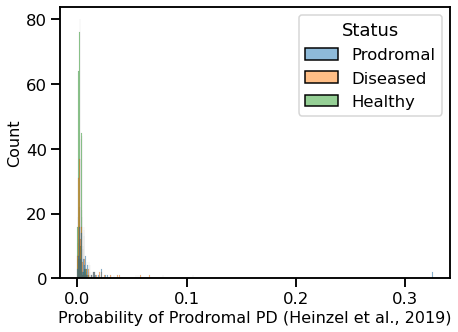

In [56]:
fig = plt.figure(figsize=(7,5))
plots.plot_context()
ax = sns.histplot(data=df,hue='Status',x='prob_PD')
ax.set_xlabel('Probability of Prodromal PD (Heinzel et al., 2019)');

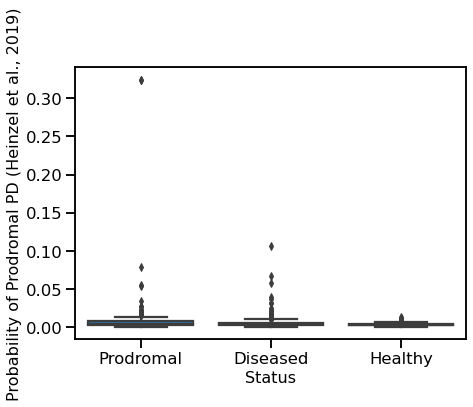

In [57]:
fig = plt.figure(figsize=(7,5))
plots.plot_context()
ax = sns.boxplot(data=df,x='Status',y='prob_PD')
ax.set_ylabel('Probability of Prodromal PD (Heinzel et al., 2019)');

diagnosis             Status   
Healthy               Healthy      1961
AllCauseDementia      Prodromal     243
                      Diagnosed     712
AlzheimerDisease      Prodromal     105
                      Diagnosed      41
Dystonia              Diagnosed      46
AllCauseParkinsonism  Prodromal       8
                      Diagnosed      27
ParkinsonDisease      Prodromal     196
                      Diagnosed     273
dtype: int64


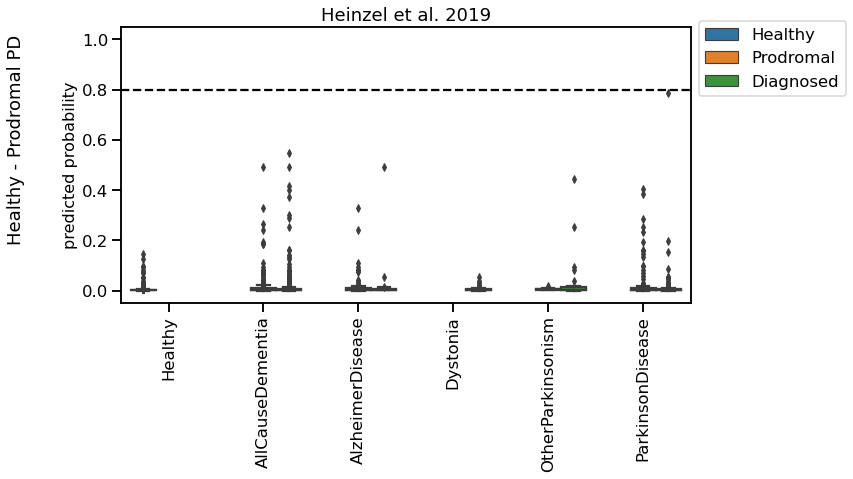

In [58]:
# load predictions
kind = ['all_acc_features']
diags = ['diag_ProdPopulationNoPD','diag_PDPopulationNoProd']
statuses = [["Prodromal"],['Diseased'],['Prodromal','Diseased']]
status_names = ['Prodromal','Diagnosed','Prodromal & Diagnosed']
hue_order=['Healthy','Prodromal','Diagnosed']
order=['Healthy','AllCauseDementia','AlzheimerDisease','Dystonia','AllCauseParkinsonism',
                                                                            'ParkinsonDisease']
remove = 20
subplotlabels = ['A','B','C']

fig = plt.figure(figsize=(10,7))
plots.plot_context()


PDcases = dfs[np.logical_and(dfs['diagnosis']=='ParkinsonDisease',dfs['Status'].isin(statuses[-1]))]
nonPD = dfs[np.logical_and(dfs['diagnosis']!='ParkinsonDisease',dfs['Status']!='Healthy')]
nonPD = nonPD.drop(index=np.intersect1d(PDcases.index,nonPD.index))
# merge HC in one group and drop duplicates
hc = dfs[dfs['Status']=='Healthy']
hc = hc[~hc.index.duplicated(keep='first')]
preddf = pd.concat([PDcases,nonPD,hc])
preddf['diagnosis'] = [row['diagnosis'] if row['Status']!='Healthy' else 'Healthy' for key,row in preddf.iterrows()]
preddf = preddf[preddf['diagnosis'].isin(order)]
preddf = preddf.reset_index().set_index(['eid','diagnosis'])
merged = pd.merge(preddf,pred.iloc[:,-4:],right_index=True,left_index=True,how='right').reset_index().set_index('eid')
merged['Status'] = merged['Status'].replace(['Diseased'],['Diagnosed'])

merged_cv = merged.reset_index().groupby(['eid','diagnosis','Status']).first()
N_diagnosis_group = merged_cv.groupby(['diagnosis','Status']).size()
N_diagnosis_group = N_diagnosis_group.loc[(order,hue_order)]

merged_cv = merged.reset_index().groupby(['eid','diagnosis','Status'])['prob_PD'].mean().reset_index()
ax = sns.boxplot(y='prob_PD',x='diagnosis',hue='Status',data=merged_cv,showfliers=True,
                 hue_order=['Healthy','Prodromal','Diagnosed'],order=['Healthy','AllCauseDementia','AlzheimerDisease','Dystonia','AllCauseParkinsonism',
                                                                    'ParkinsonDisease'])
ax.axhline(0.8,0,1,ls='--',color='k')
ax.set_ylabel(f'predicted probability')
ax.text(-1.7,0.2,f'Healthy - Prodromal PD',rotation=90)
ax.set_xticklabels(['Healthy','AllCauseDementia','AlzheimerDisease','Dystonia','OtherParkinsonism',
                                                                    'ParkinsonDisease'],rotation=90);
print(N_diagnosis_group)
#plots.add_median_labels(ax,N_diagnosis_group,fmt="%d")
ax.set_xlabel('')
ax.set_ylim(-0.05,1.05)
ax.set_title(f"Heinzel et al. 2019")

plt.legend(bbox_to_anchor=(1, 1.05))
plt.tight_layout()
#plt.savefig(f'{image_path}/barplot_probacombined_populationmodel_{k}_stacked_cvNoDepNoOst.pdf',dpi=300,bbox_inches='tight')
#plt.savefig(f'{image_path}/barplot_probacombined_populationmodel_{k}_stacked_cvNoDepNoOst.png',dpi=300,bbox_inches='tight')
plt.show()